# 卷积神经网络的艺术风格转移
这个iPython笔记本是一个流行的文章（Gatys等人，2015年）的实现，演示了如何使用神经网络将艺术风格从一个图像转移到另一个图像上。 这是为了与一个相关的博客文章一起提供更多的上下文，并解释了许多后续步骤背后的理论。
将来会有一个伴随的博客文章和项目即将推出，该功能实现了该算法的更快版本（Johnson et al。，2016），并将其包装在一个webapp，一个prisma中。

In [2]:
import time
from PIL import Image
import numpy as np
from keras import backend
from keras.applications.vgg16 import VGG16
from keras.models import Model

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave


# 加载和预处理内容和样式图像
我们的第一个任务是加载内容和样式图像。 请注意，我们正在使用的内容图像质量不是很高，但是我们在这个过程结束时到达的输出仍然看起来真的很好。

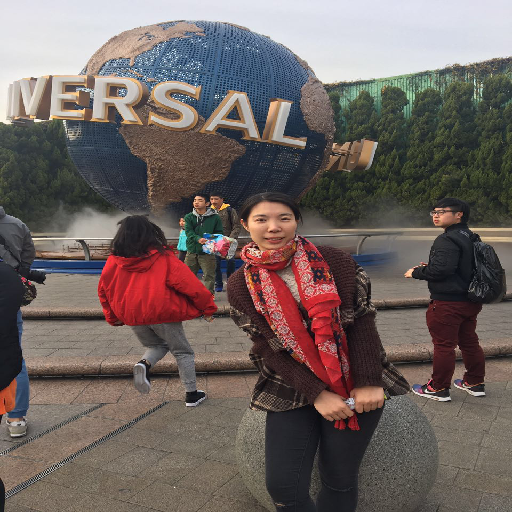

In [34]:
img_width =512
img_heigth =512

convert_image_path  ='images/2.jpeg'
convert_image = Image.open(convert_image_path)
convert_image = convert_image.resize((img_width,img_heigth))

convert_image

## 读取风格图片
读取风格图片，用于风格迁移学习

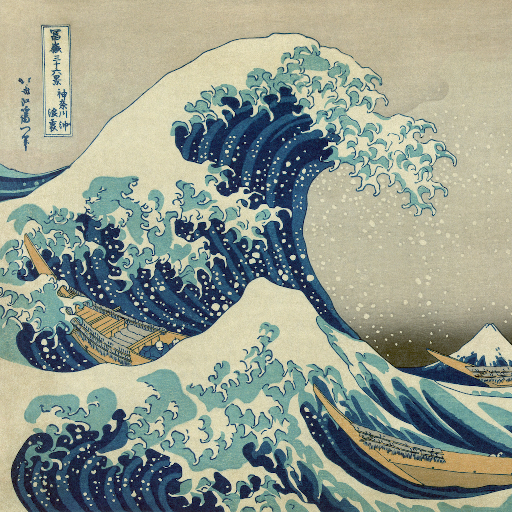

In [35]:
style_image_path = 'images/style/wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((img_width,img_heigth))

style_image

然后，我们将这些图像转换成适合数字处理的形式。 特别地，我们添加另一个维度（超出经典高度x宽度x 3维度），以便我们以后可以将这两个图像的表示连接成一个公共数据结构。

In [36]:
convert_array = np.asarray(convert_image,dtype='float32')
convert_array = np.expand_dims(convert_array,axis=0)
print(convert_array.shape)

style_array = np.asanyarray(style_image,dtype='float32')
style_array = np.expand_dims(style_array,axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


在我们进一步推进之前，我们需要按照这些输入数据来匹配Simonyan和Zisserman（2015）中所做的工作，这篇文章介绍了即将使用的VGG网络模型。
https://arxiv.org/abs/1409.1556

为此，我们需要执行两个转换：
1. **从每个像素减去平均RGB值（以前在ImageNet培训集上计算并可从Google搜索中轻松获取）。http://image-net.org/**
2. **将多维数组的排序从RGB翻转到BGR（本文中使用的顺序）。**

In [37]:
convert_array[:, :, :, 0] -= 103.939 #每个像素都减去一个平均值
convert_array[:, :, :, 1] -= 116.779
convert_array[:, :, :, 2] -= 123.68
convert_array = convert_array[:, :, :, ::-1] #将多维数组的排序从RGB翻转到BGR

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

现在我们准备使用这些数组来定义Keras后端（TensorFlow图）中的变量。 我们还引入一个占位符变量来存储保留内容图像内容的组合图像，同时结合样式图像的样式。

In [38]:
convert_image = backend.variable(convert_array)
style_image = backend.variable(style_array)

combination_image = backend.placeholder((1,img_width,img_heigth,3))

最后，我们将所有这些图像数据连接成一个适合Keras VGG16模型处理的张量。

In [39]:
input_tensor = backend.concatenate([convert_image,style_image,combination_image],axis=0)

## 重新使用预先训练图像分类的模型来定义损失函数

[Gatys et al。 （2015）]（https://arxiv.org/abs/1508.06576 ）是针对图像分类预先训练的卷积神经网络（CNN）已经知道如何编码关于图像的感知和语义信息。我们将遵循他们的想法，并使用一个这样的模型提供的*特征空间*独立地处理图像的内容和风格。

原始文件使用[Simonyan和Zisserman（2015）]（https://arxiv.org/abs/1409.1556 ）中的19层VGG网络模型，但我们将依次遵循[Johnson et al。 （2016）]（https://arxiv.org/abs/1603.08155 ），并使用16层模型（VGG16）。做出这个选择没有明显的质的差异，我们获得了一点点速度。

此外，由于我们对分类问题不感兴趣，因此我们不需要完全连接的层或最终的softmax分类器。我们只需要在下表中以绿色标示的模型的部分。

![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

对于我们来说，访问这个截断的模型是微不足道的，因为Keras带有一组预先训练的模型，包括我们感兴趣的VGG16模型。请注意，通过在下面的代码中设置“include_top = False”，我们不包括任何完全连接的层。

In [40]:
model = VGG16(input_tensor=input_tensor,weights='imagenet',include_top=False)

从上表可以看出，我们正在使用的模型有很多层次。 克拉斯有这些层的自己的名字。 让我们列出这些名称，以便稍后我们可以轻松地参考各个层。

如果你盯着上面的列表，你会说服自己，我们涵盖了我们在桌子上所需要的所有项目（细胞标记为绿色）。 还要注意的是，由于我们为Keras提供了一个具体的输入张量，各种TensorFlow张量得到了明确的形状。

---

我们试图复制的论文的重点是[风格转移问题可以作为优化问题]（https://harishnarayanan.org/writing/artistic-style-transfer/ ），其中损失函数我们 要最小化可以分解为三个不同的部分：*内容丢失*，*风格损失*和*总变异损失*。

这些术语的相对重要性由一组标量权重确定。 这些是任意的，但是经过相当多的实验之后，已经选择了以下集合，以找到一组产生美观的产品。

In [41]:
convert_weigth = 0.025
style_weight =5.0
total_variation_weight = 1.0

我们现在将使用我们模型的特定层提供的特征空间来定义这三个损失函数。 我们首先将总损失初始化为0，并分阶段加入。

In [42]:
loss = backend.variable(0.)

### 内容丢失

对于内容丢失，我们遵循Johnson等人 （2016），并从“block2_conv2”中绘制内容特征，因为Gatys等人的原始选择 （2015）（`block4_conv2`）失去了太多的结构细节。 至少对于面孔，我觉得更加美观地保持原始内容形象的结构。

在下面的图像中，显示了这两个层次的变化（只是用我们的Keras符号'blockX_convY'精神上替换'reluX_Y'）。

![Content feature reconstruction](images/content-feature.png "Content feature reconstruction")

内容丢失是内容和组合图像的特征表示之间的（缩放，平方）欧几里得距离。

In [43]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [44]:
def convert_loss(content,combination):
    #内容丢失是内容和组合图像的特征表示之间的（缩放，平方）欧几里得距离。
    return backend.sum(backend.square(combination - content))


layer_features = layers['block2_conv2']
convert_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += convert_weigth * convert_loss(convert_image_features,
                                      combination_features)

### 风格损失

这是事情开始有点复杂的地方。

对于风格的损失，我们首先定义一个叫做*格式矩阵的东西。 该矩阵的项与成对的特征集合的协方差成比例，从而捕获关于哪些特征一起激活的信息。 通过在整个图像中捕获这些聚合统计数据，它们对图像内的对象的具体布置无视。 这是允许他们捕获独立于内容的风格的信息。 （这根本不是微不足道的，我提到你[试图解释这个想法的一篇文章]（https://arxiv.org/abs/1606.01286 ））

可以通过适当地重新组合特征空间并获取外部产物来有效地计算Gram矩阵。

In [45]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

风格损失是风格和组合图像的格式矩阵之间差异的（缩放，平方）Frobenius范数。

再次，在下面的代码中，我选择了与Johnson等人定义的层的风格特征。 （2016），而不是Gatys等人 （2015）因为我觉得最终的结果更美观。 我鼓励你尝试这些选择来看看不同的结果。

In [46]:
def style_loss(style,combination):
    S =gram_matrix(style)
    C =gram_matrix(combination)
    channels = 3
    size = img_heigth*img_width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### 总变异损失

现在我们回到了更简单的地步。

如果要解决优化问题，只有我们迄今为止介绍的两个损失条款（样式和内容），您会发现输出相当嘈杂。 因此，我们增加了另一个术语，称为[总变异损失]（http://arxiv.org/abs/1412.0035 ）（正则化术语），鼓励空间平滑。

您可以尝试减少“total_variation_weight”并播放生成的图像的噪声级别。

In [47]:
def total_variation_loss(x):
    a = backend.square(x[:, :img_heigth-1, :img_width-1, :] - x[:, 1:, :img_width-1, :])
    b = backend.square(x[:, :img_heigth-1, :img_width-1, :] - x[:, :img_heigth-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## 定义所需的梯度并解决优化问题

[这个旅程的目标]（https://harishnarayanan.org/writing/artistic-style-transfer/ ）是设置一个优化问题，旨在解决包含内容图像内容的*组合图像* 同时具有风格形象的风格。 现在我们有输入图像按摩和我们的损失函数计算器到位，我们所要做的就是定义相对于组合图像的总损耗的梯度，并使用这些梯度来迭代地改进我们的组合图像以最小化损失。

我们首先定义渐变。

In [48]:
grads = backend.gradients(loss,combination_image)

然后，我们引入一个Evaluator类，可以在一次通过中计算丢失和渐变，同时通过两个单独的函数（丢失和分数）来检索它们。 这样做是因为scipy.optimize需要单独的损失和渐变功能，而是单独计算它们将是低效的。

In [49]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, img_heigth, img_width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

现在我们终于准备好解决我们的优化问题了。 这个组合图像作为随机的（有效）像素集合开始生命，我们使用[L-BFGS]（https://en.wikipedia.org/wiki/Limited-memory_BFGS ）算法（一个准牛顿算法 比标准梯度下降明显更快地收敛），以反复改进。

我们在10次迭代后停止，因为输出对我来说很好，而且损失显着下降。

In [50]:
x = np.random.uniform(0, 255, (1, img_heigth, img_width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 7.46079e+10
Iteration 0 completed in 699s
Start of iteration 1
Current loss value: 3.89965e+10
Iteration 1 completed in 676s
Start of iteration 2
Current loss value: 2.71617e+10
Iteration 2 completed in 676s
Start of iteration 3
Current loss value: 2.27169e+10
Iteration 3 completed in 684s
Start of iteration 4
Current loss value: 2.12484e+10
Iteration 4 completed in 683s
Start of iteration 5
Current loss value: 2.04799e+10
Iteration 5 completed in 691s
Start of iteration 6
Current loss value: 1.99813e+10
Iteration 6 completed in 658s
Start of iteration 7
Current loss value: 1.9669e+10
Iteration 7 completed in 666s
Start of iteration 8
Current loss value: 1.94848e+10
Iteration 8 completed in 702s
Start of iteration 9
Current loss value: 1.93739e+10
Iteration 9 completed in 701s


这在笔记本电脑上花费了一段时间（这不是GPU加速的），但是这是最后一次迭代的美丽输出！ （请注意，在有意义的情况下，我们需要将输出图像与我们对输入图像进行的转换相反。）

In [51]:
x = x.reshape((img_heigth, img_width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

img_final =Image.fromarray(x)
img_final.save('result2.bmp')

## 结论和进一步的改进

现在轮到你玩了！尝试改变输入图像，它们的尺寸，不同损耗函数的权重，用于构造它们的特征并享受不同类型的输出。如果你最终创造出真正希望分享的东西，请[这样做]（https://twitter.com/copingbear ）！

像这个代码的输出一样漂亮，我们用来生成它的过程是相当慢的。无论你加快这个算法的速度（GPU和创意黑客），还是要解决一个比较昂贵的问题。这是因为我们每次要生成图像时都会解决整个优化问题。

在即将到来的文章（和相应的iPython笔记本）中，我们将用图像转换CNN替代这个优化问题，后者又像以前一样使用VGG16网络来测量损失。当这个转换网络被训练在给定固定风格图像的许多图像上时，我们最终得到一个完全前馈的CNN，我们可以申请样式转移。这给我们提供了1000倍的速度，使其适用于* Stylist * webapp。